In [2]:
import sys

sys.path.append("../")
import os
import random
import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

## Torch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler, Adam, SGD

## Torchvision imports
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision

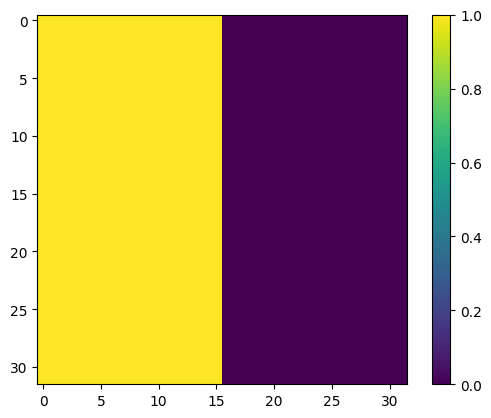

In [3]:
# choices=list(np.load('test.npy'))
mask= torch.zeros(32 * 32)
# mask[choices] = 1
mask          = mask.view(32,32)
mask[:, 0:16] = 1
plt.imshow(mask)
plt.colorbar()

In [ ]:
%mkdir masks
%mkdir labels

# Dataset Creation

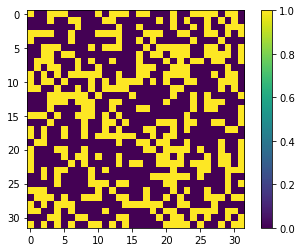

In [ ]:
ch = np.random.randint(low=0, high=1024, size=512)
mask1 = torch.zeros(32 * 32)
mask1[ch] = 1
mask1          = mask1.view(32,32)
plt.imshow(mask1)
plt.colorbar()
torch.save(mask1, "masks/random_mask1")

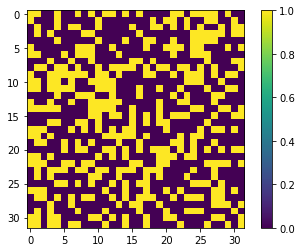

In [ ]:
ch = np.random.randint(low=0, high=1024, size=512)
mask1 = torch.zeros(32 * 32)
mask1[ch] = 1
mask1          = mask1.view(32,32)
plt.imshow(mask1)
plt.colorbar()
torch.save(mask1, "masks/random_mask1")
torch.save(mask,"labels/oracle_mask1")

In [ ]:
class NewDataset(Dataset):
    def __init__(
        self,
        mask_path,
        label_path,
    ):
        self.mask_path  = mask_path
        self.labels_path = label_path
        self.len = len(os.listdir(self.mask_path))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        ls_mask = sorted(os.listdir(self.mask_path))
        ls_label = sorted(os.listdir(self.labels_path))
        
        mask_file_path = os.path.join(self.mask_path, ls_mask[idx])
        mask_tensor = torch.load(mask_file_path)

        label_file_path = os.path.join(self.labels_path, ls_label[idx])
        label = torch.load(label_file_path)

        return mask_tensor, label

# Model Creation

In [ ]:
class CNNSamplerNetwork(nn.Module):
    def __init__(self, sparsity):
        super(CNNSamplerNetwork, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=int(sparsity*32*32),
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
        )
        
        self.drop = nn.Dropout2d(0.25)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.deconv_block1(x)
        x = self.deconv_block2(x)
        # print("Shape after deconv block {}".format(x.shape))
        x = torch.flatten(x, start_dim = -2, end_dim = -1)
        # print("Shape after flattening {}".format(x.shape))
        x = nn.functional.gumbel_softmax(x, tau=100, hard = True)
        # print("Shape after gumbel {}".format(x.shape))
        x = torch.sum(x, dim = -2)
        # print("Shape after sum after gumbel {}".format(x.shape))
        x = torch.reshape(x, (-1, 32, 32))
        x = torch.unsqueeze(x, 1)
        # print("Shape of gumbel sampler output {}".format(x.shape))
        # out = torch.sigmoid(x)
        out = x

        return out


# Training

In [ ]:
class TrainingHarness:
  def __init__(self, training_params):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(self.device)
    self.sampler = training_params["sampler"].to(self.device)

    self.sampler_optimizer = Adam(self.sampler.parameters(), lr=0.05)
    self.train_dl = training_params["train_dl"]
    self.criterion = nn.MSELoss()

    self.sampler_scheduler = lr_scheduler.OneCycleLR(
        self.sampler_optimizer,
        0.1,
        epochs=training_params["epochs"],
        steps_per_epoch=len(self.train_dl),
        three_phase=True,
    )

  def forward_only_sampler(self, x):
    sampler_mask = self.sampler(x)
    return sampler_mask

  def forward_with_sampler(self, x, label):
      sampler_mask = x.unsqueeze(1)
      labels = label.unsqueeze(1)
      total_loss = 0.0
      input_x = sampler_mask

      sampler_pred = self.forward_only_sampler(input_x)

      loss = self.criterion(sampler_pred, labels)
      total_loss += loss

      return total_loss, sampler_pred

  def train_only_sampler(self, epoch):
      self.sampler.train()
      train_loss = 0.0
      train_correct = 0
      total = 0
      for data in tqdm.tqdm(self.train_dl):
          ims, labels = data
          ims, labels = (
              ims.to(self.device),
              labels.to(self.device),
          )

          self.sampler_optimizer.zero_grad()
          sampler_loss, sampler_output = self.forward_with_sampler(
              ims, labels)
          # if epoch % 10 == 0:
          #     self.plot_image_grid(
          #         [
          #             ims[5].permute(1, 2, 0).detach().cpu().numpy(),
          #             sampler_mask[5].permute(1, 2, 0).detach().cpu().numpy(),
          #             sampler_mask[5].permute(1, 2, 0).detach().cpu().numpy(),
          #             ims[10].permute(1, 2, 0).detach().cpu().numpy(),
          #             sampler_mask[10].permute(1, 2, 0).detach().cpu().numpy(),
          #             sampler_mask[10].permute(1, 2, 0).detach().cpu().numpy(),
          #             ims[15].permute(1, 2, 0).detach().cpu().numpy(),
          #             sampler_mask[15].permute(1, 2, 0).detach().cpu().numpy(),
          #             sampler_mask[15].permute(1, 2, 0).detach().cpu().numpy(),
          #         ],
          #     )

          sampler_loss.backward()
            # plt.imshow(sampler_output.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
            # print("Sampler Output size: {}".format(sampler_output.squeeze(0).shape))
          # self.plot_grad_flow(self.sampler.named_parameters())
          # print("Number of layers= {}".format(type(self.sampler.named_parameters())))
          # print("Number of from weight layers= {}".format(self.sampler.deconv_block2[-1].weight.grad))
          self.sampler_optimizer.step()
          self.sampler_scheduler.step()
          train_loss += sampler_loss.item()
          # plt.show()
      train_loss /= len(self.train_dl)
      # print("Train Loss: {}, Epoch: {}".format(train_loss, epoch))
      return train_loss, sampler_output


In [ ]:
def train_experiment(sparsity_mask):

    train_params = {}
    train_params["epochs"] = 1000
    train_params["batch_size"] = 32
    train_params["is_deterministic"] = False
    train_params["sampler"] = CNNSamplerNetwork(sparsity_mask)
    train_params["sampler_lr"] = 0.05
    train_params["mask_sparsity"] = sparsity_mask

    train_dataset = NewDataset("masks", "labels")

    train_dl = DataLoader(
        train_dataset,
        batch_size=train_params["batch_size"],
        shuffle=True,
        num_workers=2,
    )
    #print(train_dl)

    train_params["train_dl"] = train_dl
    training_run = TrainingHarness(training_params=train_params)

    loss, epoch_list = [], []
    num_epochs = train_params["epochs"]
    for epoch in range(num_epochs):
        train_loss, sampler_output = training_run.train_only_sampler(epoch)
        if epoch == 0 or epoch == (num_epochs-1):
          torch.save(sampler_output, "results/ep_{}".format(epoch))
        loss.append(train_loss)
        epoch_list.append(epoch)

    print("Final loss {}".format(loss[-1]))
    # plt.imshow(sampler_output.squeeze(0).squeeze(0).detach())
    # plt.colorbar()
    plt.plot(epoch_list, loss)

In [ ]:
%mkdir results

cpu


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


Final loss 0.505859375


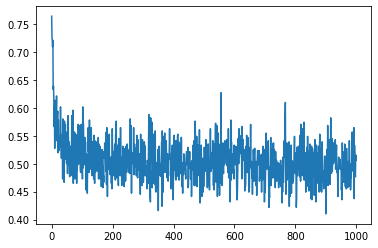

In [ ]:
train_experiment(0.5)

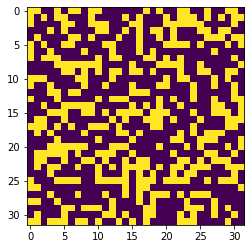

In [ ]:
choices=list(np.load('test.npy'))
mask= torch.zeros(32 * 32)
mask[choices] = 1
mask          = mask.view(32,32)
mp.imshow(mask)

In [ ]:
tau = ((10, 0.52), (100, 0.4609), (1000, ))

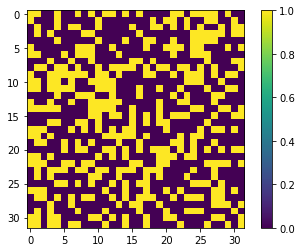

In [ ]:
plt.imshow(mask1)
plt.colorbar()

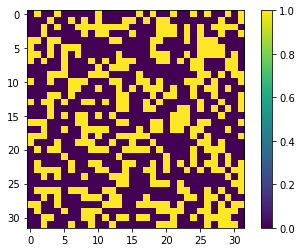

In [ ]:
ep_0 = torch.load("results/ep_0")
final0 = ep_0.squeeze(0).permute(1, 2, 0).detach()
final0 = (final0 > 0.5).float()
plt.imshow(final0)
plt.colorbar()

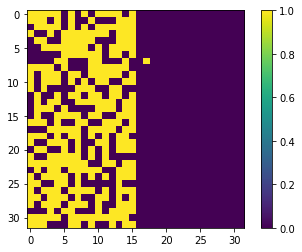

In [ ]:
ep_1 = torch.load("results/ep_999")
final1 = ep_1.squeeze(0).permute(1, 2, 0).detach()
final1 = (final1 > 0.5).float()
plt.imshow(final1)
plt.colorbar()

Text(0.5, 1.0, 'Oracle mask')

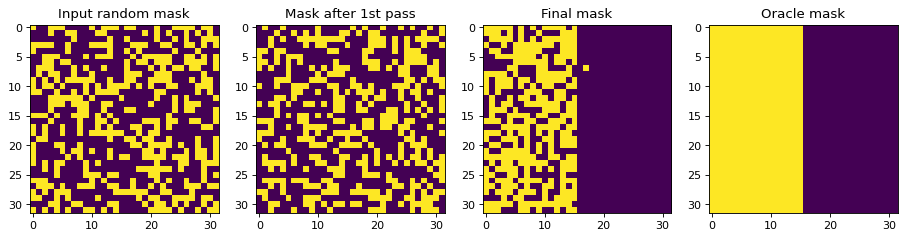

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(14, 8), dpi=80)


plt.subplot(1, 4, 1)
plt.imshow(mask1)

plt.title("Input random mask")

plt.subplot(1, 4, 2)
plt.imshow(final0)

plt.title("Mask after 1st pass")

plt.subplot(1, 4, 3)
plt.imshow(final1)

plt.title("Final mask")

plt.subplot(1, 4, 4)
plt.imshow(mask)

plt.title("Oracle mask")

In [ ]:
mask = torch.zeros(32, 32)

In [ ]:
mask.shape

torch.Size([32, 32])

In [ ]:
mask[:, :16] = 1

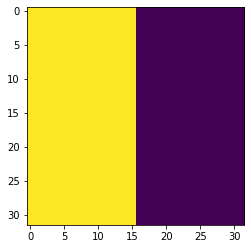

In [ ]:
plt.imshow(mask)

In [ ]:
torch.save(mask, "labels/left_mask")

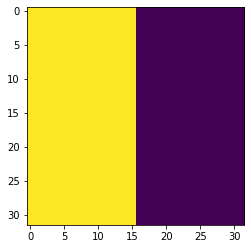

In [ ]:
p = torch.load("labels/left_mask")
plt.imshow(p)

In [ ]:
%rm -rf labels/

In [ ]:
%mkdir labels/

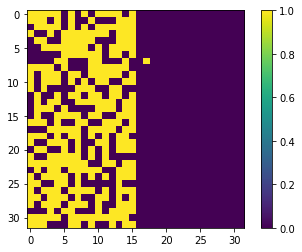

In [ ]:
final_to = torch.load("results/ep_999")
final_to = final_to.squeeze(0).permute(1, 2, 0).detach()
final_to = (final_to > 0.5).float()
plt.imshow(final_to)
plt.colorbar()